In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight, resample

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

2025-05-30 13:51:13.231802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748613073.750739      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748613073.879768      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#dataframe
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [4]:
clases_original = train_df[187].value_counts().sort_index()
print("Original class distribution:")
print(clases_original)

Original class distribution:
187
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64


Text(0.5, 1.0, 'Original Training Data Distribution')

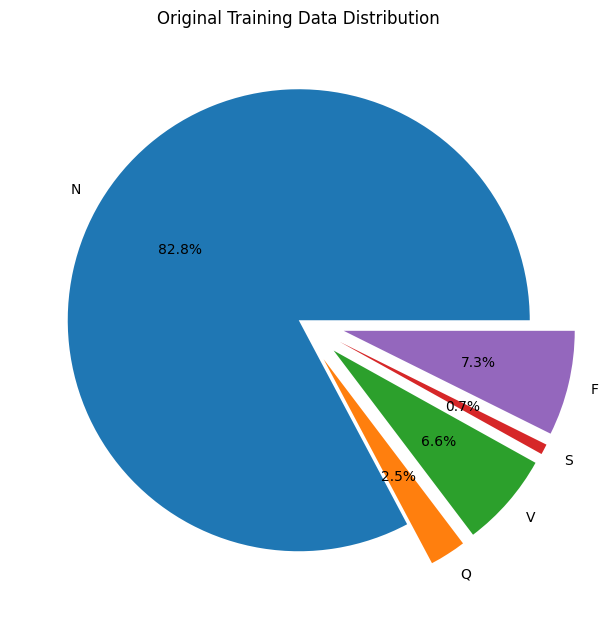

In [5]:
plt.figure(figsize=(7.5,7.5))
explode = (0, 0.2, 0.2, 0.2, 0.2)
plt.pie(clases_original, labels=['N','Q','V','S','F'], autopct='%0.1f%%', explode=explode)
plt.title("Original Training Data Distribution")

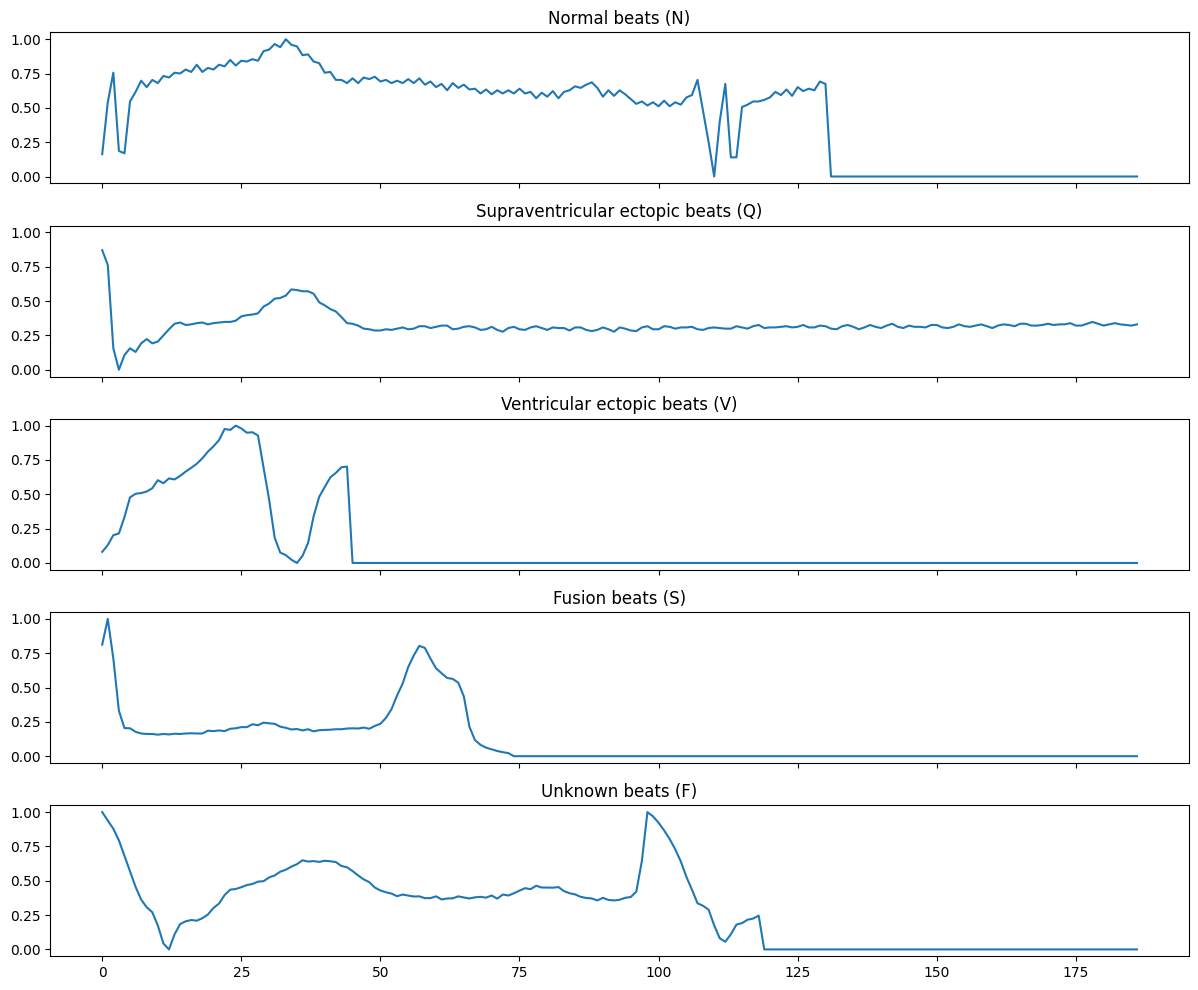

In [6]:
df_0_orig = train_df[train_df[187]==0.0]
df_1_orig = train_df[train_df[187]==1.0]
df_2_orig = train_df[train_df[187]==2.0]
df_3_orig = train_df[train_df[187]==3.0]
df_4_orig = train_df[train_df[187]==4.0]

sample_n = df_0_orig.sample(1, random_state=42)
sample_q = df_1_orig.sample(1, random_state=42)
sample_v = df_2_orig.sample(1, random_state=42)
sample_s = df_3_orig.sample(1, random_state=42)
sample_f = df_4_orig.sample(1, random_state=42)

fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(12, 10))
ax[0].plot(sample_n.iloc[0,:187])
ax[0].set_title("Normal beats (N)")
ax[1].plot(sample_q.iloc[0,:187])
ax[1].set_title("Supraventricular ectopic beats (Q)")
ax[2].plot(sample_v.iloc[0,:187])
ax[2].set_title("Ventricular ectopic beats (V)")
ax[3].plot(sample_s.iloc[0,:187])
ax[3].set_title("Fusion beats (S)")
ax[4].plot(sample_f.iloc[0,:187])
ax[4].set_title("Unknown beats (F)")
plt.tight_layout()
plt.show()

In [7]:
# Handle class imbalance on training data only
print("=== Handling Class Imbalance ===")

# Separate classes
df_0 = train_df[train_df[187]==0.0]  # Normal beats
df_1 = train_df[train_df[187]==1.0]  # Q beats
df_2 = train_df[train_df[187]==2.0]  # V beats  
df_3 = train_df[train_df[187]==3.0]  # S beats
df_4 = train_df[train_df[187]==4.0]  # F beats

print("Original class sizes:")
print(f"Class 0 (N): {len(df_0)}")
print(f"Class 1 (Q): {len(df_1)}")
print(f"Class 2 (V): {len(df_2)}")
print(f"Class 3 (S): {len(df_3)}")
print(f"Class 4 (F): {len(df_4)}")

# Downsample majority class
df_0_sampled = df_0.sample(n=16000, random_state=42)

# Upsample minority classess
df_1_up = resample(df_1, replace=True, n_samples=16000, random_state=42)
df_2_up = resample(df_2, replace=True, n_samples=16000, random_state=42)  
df_3_up = resample(df_3, replace=True, n_samples=16000, random_state=42)
df_4_up = resample(df_4, replace=True, n_samples=16000, random_state=42)

print("Balanced class sizes:")
print(f"Class 0 (N): {len(df_0_sampled)}")
print(f"Class 1 (Q): {len(df_1_up)}")
print(f"Class 2 (V): {len(df_2_up)}")
print(f"Class 3 (S): {len(df_3_up)}")
print(f"Class 4 (F): {len(df_4_up)}")

# Combine balanced training data
train_df_balanced = pd.concat([df_0_sampled, df_1_up, df_2_up, df_3_up, df_4_up])

print("*" * 30)
print(f"Balanced training data shape: {train_df_balanced.shape}")

=== Handling Class Imbalance ===
Original class sizes:
Class 0 (N): 72471
Class 1 (Q): 2223
Class 2 (V): 5788
Class 3 (S): 641
Class 4 (F): 6431
Balanced class sizes:
Class 0 (N): 16000
Class 1 (Q): 16000
Class 2 (V): 16000
Class 3 (S): 16000
Class 4 (F): 16000
******************************
Balanced training data shape: (80000, 188)


In [8]:
clases_balanced = train_df_balanced[187].value_counts().sort_index()
print("Balanced class distribution:")
print(clases_balanced)

Balanced class distribution:
187
0.0    16000
1.0    16000
2.0    16000
3.0    16000
4.0    16000
Name: count, dtype: int64


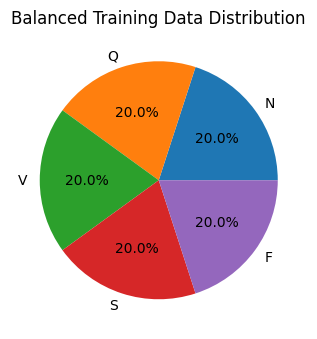

In [9]:
plt.subplot(1, 2, 2)
plt.pie(clases_balanced, labels=['N','Q','V','S','F'], autopct='%0.1f%%')
plt.title("Balanced Training Data Distribution")
plt.tight_layout()
plt.show()

In [11]:
print(" Preparing Data for Model ")

X_full = train_df_balanced.iloc[:, :187].values.astype("float32")
y_full = train_df_balanced[187].values.astype("int32")

X_full = X_full.reshape(-1, 187, 1)

X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X_full, y_full,
    test_size=0.20,
    stratify=y_full,
    random_state=42
)

y_train = to_categorical(y_train_raw, num_classes=5)
y_val = to_categorical(y_val_raw, num_classes=5)

X_test = test_df.iloc[:, :187].values.astype("float32").reshape(-1, 187, 1)
y_test_raw = test_df[187].values.astype("int32")
y_test = to_categorical(y_test_raw, num_classes=5)

print("Data shapes:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

 Preparing Data for Model 
Data shapes:
Train: (64000, 187, 1), (64000, 5)
Val:   (16000, 187, 1), (16000, 5)
Test:  (21892, 187, 1), (21892, 5)


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling1D
from keras.models import Sequential

In [13]:
cnn = Sequential()
cnn.add(Conv1D(128,3,input_shape=(X_train.shape[1],1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748613105.033750      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748613105.034468      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 185, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 185, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 44, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,429 (872.77 KB)

 Trainable params: 222,917 (870.77 KB)

 Non-trainable params: 512 (2.00 KB)

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_ecg_model_2.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]

In [16]:
cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [17]:
history = cnn.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1748613112.503755      63 service.cc:148] XLA service 0x7bdc24017660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748613112.504890      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748613112.504909      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748613113.083492      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  36/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4477 - loss: 1.4524 - precision: 0.5664 - recall: 0.2614

I0000 00:00:1748613117.905224      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1987/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8138 - loss: 0.5039 - precision: 0.8660 - recall: 0.7670
Epoch 1: val_loss improved from inf to 0.25917, saving model to best_ecg_model_2.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8142 - loss: 0.5028 - precision: 0.8662 - recall: 0.7675 - val_accuracy: 0.9003 - val_loss: 0.2592 - val_precision: 0.9147 - val_recall: 0.8852 - learning_rate: 0.0010
Epoch 2/100
1986/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9326 - loss: 0.1906 - precision: 0.9434 - recall: 0.9219
Epoch 2: val_loss improved from 0.25917 to 0.09926, saving model to best_ecg_model_2.h5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9327 - loss: 0.1904 - precision: 0.9434 - recall: 0.9219 - val_accuracy: 0.9603 - val_loss: 0.0993 - val_precision: 0.9635 - val_recall: 0.9572 - learning_rate: 0.0010
Epoch 3/100
1987/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1319 - precision: 0.9603 - recall: 0.9483
Epoch 3: va

In [18]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 185, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 185, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 44, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         172,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,265 (2.55 MB)

 Trainable params: 222,917 (870.77 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 445,836 (1.70 MB)

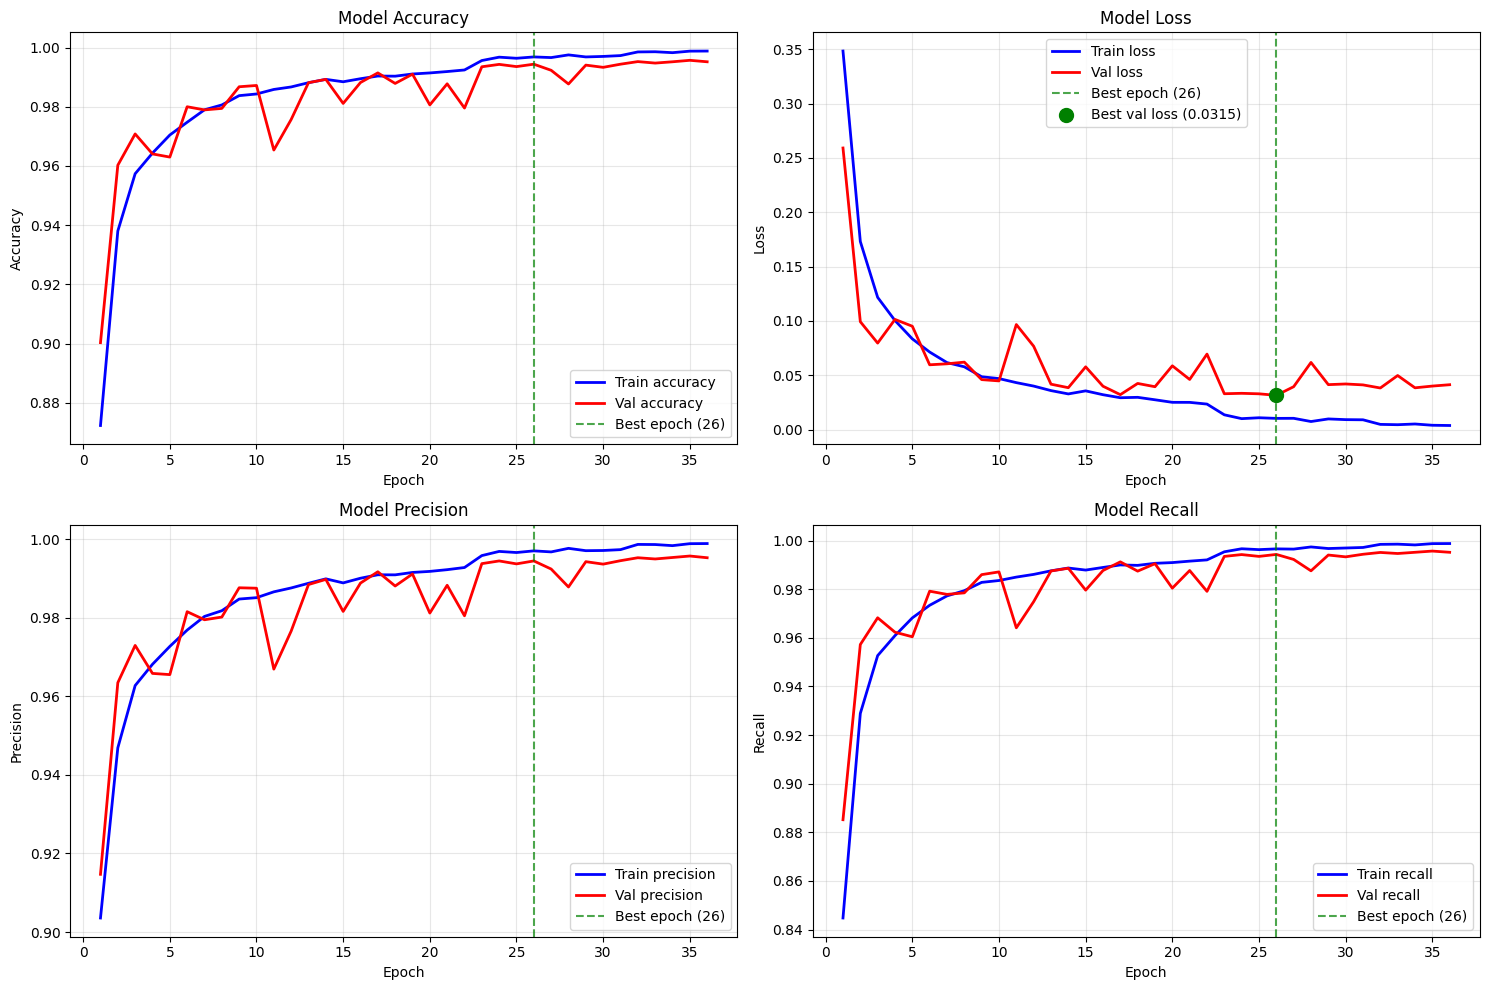

In [19]:
import matplotlib.pyplot as plt
import numpy as np

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"] 
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_precision = history.history["precision"]
val_precision = history.history["val_precision"]
train_recall = history.history["recall"]
val_recall = history.history["val_recall"]

epochs = range(1, len(train_loss) + 1)

best_epoch = np.argmin(val_loss) + 1
best_val_loss = min(val_loss)

plt.figure(figsize=(15, 10))

# plot 1: Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_acc, 'b-', label="Train accuracy", linewidth=2)
plt.plot(epochs, val_acc, 'r-', label="Val accuracy", linewidth=2)
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# plot 2: Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b-', label="Train loss", linewidth=2)
plt.plot(epochs, val_loss, 'r-', label="Val loss", linewidth=2)
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best epoch ({best_epoch})')
plt.scatter(best_epoch, best_val_loss, color='g', s=100, zorder=5, label=f'Best val loss ({best_val_loss:.4f})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# plot 3: Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precision, 'b-', label="Train precision", linewidth=2)
plt.plot(epochs, val_precision, 'r-', label="Val precision", linewidth=2)
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Model Precision")
plt.legend()
plt.grid(True, alpha=0.3)

# plot 4: Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recall, 'b-', label="Train recall", linewidth=2)
plt.plot(epochs, val_recall, 'r-', label="Val recall", linewidth=2)
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Model Recall")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
test_loss, test_accuracy, test_precision, test_recall = cnn.evaluate(X_test, y_test, verbose=0)

print("--- Test Set Performance ---")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

--- Test Set Performance ---
Test Accuracy:  0.9778 (97.78%)
Test Loss:      0.1424
Test Precision: 0.9782
Test Recall:    0.9775


In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Normalized confusion matrix


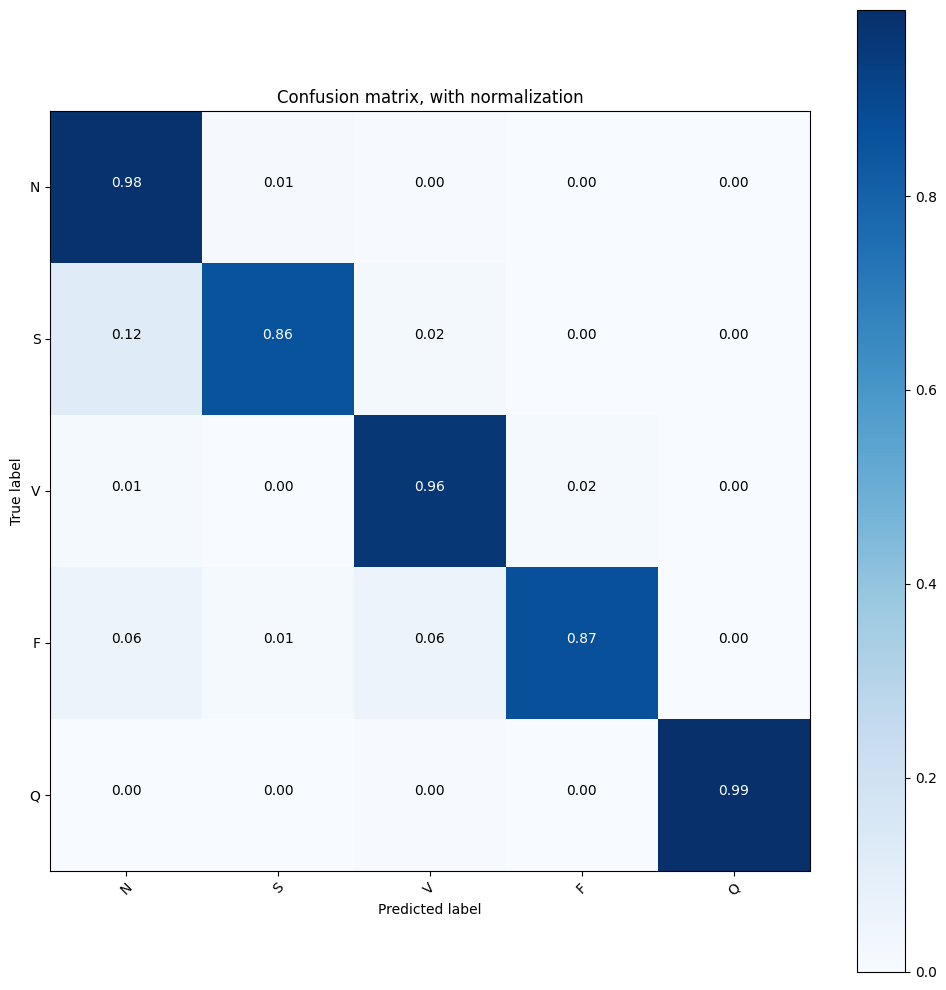

In [22]:
y_predict = cnn.predict(X_test)
cf_matrix = confusion_matrix(y_test.argmax(axis=1),y_predict.argmax(axis=1))
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,title='Confusion matrix, with normalization')
plt.show()